In this notebook, which is on the WSL(don't run on windows), we will see test the correlation between the covariances of a true MSA sampled from the PDB and the covariances found by generating sequences from both ESM and the Potts model

In [5]:
#%%script julia 
#using PlmDCA;

In [1]:
import torch
import numpy as np
import scipy
import os, sys


sys.path.insert(1, "./../util")
sys.path.insert(1, "./../model")
import biotite.structure
from biotite.structure.io import pdbx, pdb
from biotite.structure.residues import get_residues
from biotite.structure import filter_backbone
from biotite.structure import get_chains
from biotite.sequence import ProteinSequence
from typing import Sequence, Tuple, List
from Bio import SeqIO

from potts_decoder import PottsDecoder

git_folder = '/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/InverseFolding'
esm_folder = '/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/esm/'
sys.path.insert(1, os.path.join(git_folder, 'model'))
sys.path.insert(1, os.path.join(git_folder, 'util'))

sys.path.insert(1, esm_folder)
import esm
#from esm.inverse_folding import util
import esm.pretrained as pretrained

#### Code for model with PLL ########
#from potts_decoder import PottsDecoder
#### Code for model with NCE ##########
#from potts_decoder_nce import PottsDecoder
from ioutils import read_fasta, read_encodings

from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.nn.functional import one_hot

from collections import defaultdict

import matplotlib.pyplot as plt



In [2]:
def load_structure(fpath, chain=None):
    """
    Args:
        fpath: filepath to either pdb or cif file
        chain: the chain id or list of chain ids to load
    Returns:
        biotite.structure.AtomArray
    """
    with open(fpath) as fin:
        pdbf = pdb.PDBFile.read(fin)
    structure = pdb.get_structure(pdbf, model=1)
    bbmask = filter_backbone(structure)
    structure = structure[bbmask]
    all_chains = get_chains(structure)
    if len(all_chains) == 0:
        raise ValueError('No chains found in the input file.')
    if chain is None:
        chain_ids = all_chains
    elif isinstance(chain, list):
        chain_ids = chain
    else:
        chain_ids = [chain] 
    for chain in chain_ids:
        if chain not in all_chains:
            raise ValueError(f'Chain {chain} not found in input file')
    chain_filter = [a.chain_id in chain_ids for a in structure]
    structure = structure[chain_filter]
    return structure

def extract_coords_from_structure(structure: biotite.structure.AtomArray):
    """
    Args:
        structure: An instance of biotite AtomArray
    Returns:
        Tuple (coords, seq)
            - coords is an L x 3 x 3 array for N, CA, C coordinates
            - seq is the extracted sequence
    """
    coords = get_atom_coords_residuewise(["N", "CA", "C"], structure)
    residue_identities = get_residues(structure)[1]
    seq = ''.join([ProteinSequence.convert_letter_3to1(r) for r in residue_identities])
    return coords, seq

def get_atom_coords_residuewise(atoms: List[str], struct: biotite.structure.AtomArray):
    """
    Example for atoms argument: ["N", "CA", "C"]
    """
    def filterfn(s, axis=None):
        filters = np.stack([s.atom_name == name for name in atoms], axis=1)
        sum = filters.sum(0)
        if not np.all(sum <= np.ones(filters.shape[1])):
            raise RuntimeError("structure has multiple atoms with same name")
        index = filters.argmax(0)
        coords = s[index].coord
        coords[sum == 0] = float("nan")
        return coords

    return biotite.structure.apply_residue_wise(struct, struct, filterfn)

def get_loss_new(decoder, inputs, eta):
    """eta is the multiplicative term in front of the penalized negative pseudo-log-likelihood"""
    msas, encodings, padding_mask  = [input.to(device) for input in inputs]
    B, M, N = msas.shape
    #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
    param_embeddings, fields = decoder.forward_new(encodings, padding_mask)
    msas_embedded = embedding(msas)

    # get npll
    npll = get_npll2(msas_embedded, param_embeddings, fields, N, q)
    padding_mask_inv = (~padding_mask)
    # multiply with the padding mask to filter non-existing residues (this is probably not necessary)       
    npll = npll * padding_mask_inv.unsqueeze(1)
    npll_mean = torch.sum(npll) / (M * torch.sum(padding_mask_inv))
    
    Q = torch.einsum('bkuia, buhia->bkhia', 
                param_embeddings.unsqueeze(2), param_embeddings.unsqueeze(1)).sum(axis=-1)
    penalty = eta*(torch.sum(torch.sum(Q,axis=-1)**2) - torch.sum(Q**2) + torch.sum(fields**2))/B
    loss_penalty = npll_mean + penalty
    return loss_penalty, npll_mean.item() 

def get_loss(decoder, inputs, eta):
    """eta is the multiplicative term in front of the penalized negative pseudo-log-likelihood"""
    msas, encodings, padding_mask  = [input.to(device) for input in inputs]
    B, M, N = msas.shape
    #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
    couplings, fields = decoder(encodings, padding_mask)

    # embed and reshape to (B, M, N*q)
    msas_embedded = embedding(msas).view(B, M, -1)

    # get npll
    npll = get_npll(msas_embedded, couplings, fields, N, q)
    padding_mask_inv = (~padding_mask)

    # multiply with the padding mask to filter non-existing residues (this is probably not necessary)       
    npll = npll * padding_mask_inv.unsqueeze(1)
    penalty = eta*(torch.sum(couplings**2) + torch.sum(fields**2))/B

    # the padding mask does not contain the msa dimension so we need to multiply by M
    npll_mean = torch.sum(npll) / (M * torch.sum(padding_mask_inv))
    loss_penalty = npll_mean + penalty
    return loss_penalty, npll_mean.item() 
    #return loss_penalty

def get_loss_loader(decoder, loader, eta):

    decoder.eval()
    losses = 0
    iterator = 0
    with torch.no_grad():
        for inputs in loader:
            iterator+=1
            _, npll = get_loss_new(decoder, inputs, eta) 
            losses+=npll
    
    return losses/iterator

def compute_covariance(msa, q):
    """
    Compute covariance matrix of a given MSA having q different amino acids
    """
    M, N = msa.shape

    # One hot encode classes and reshape to create data matrix
    D = torch.flatten(one_hot(msa, num_classes=q), start_dim=1).to(torch.float32)

    # Remove one amino acid
    D = D.view(M, N, q)[:, :, :q-1].flatten(1)

    # Compute bivariate frequencies
    bivariate_freqs = D.T @ D / M
    
    # Compute product of univariate frequencies
    univariate_freqs = torch.diagonal(bivariate_freqs).view(N*(q-1), 1) @ torch.diagonal(bivariate_freqs).view(1, N*(q-1))

    return bivariate_freqs - univariate_freqs

In [4]:
device='cpu'
## This would work on windows
#bk_dir= 'D:/Data/InverseFolding/Intermediate_Models/'

bk_dir = "/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Intermediate_Models/"
fname_par = 'model_11_07_2023_epoch_' + str(94.0) + '_ardca' + '.pt'
#fname_par = "model_20_01_2023_epoch_1000.0.pt"
checkpoint = torch.load(os.path.join(bk_dir, fname_par))

## Load parameters of the mode,
q=21
args = checkpoint['args_run']
n_layers = args['n_layers']
param_embed_dim = d_model = args['param_embed_dim']
input_encoding_dim = args['input_encoding_dim']
n_heads=args['n_heads']
n_param_heads=args['n_param_heads']
dropout=args['dropout']

decoder = PottsDecoder(q, n_layers, d_model, input_encoding_dim, param_embed_dim, n_heads, n_param_heads, dropout=dropout);
decoder.to(device);

decoder.load_state_dict(checkpoint['model_state_dict']);
decoder.eval();   ##to generate data we need just the forward pass of the model!

In [4]:
#checkpoint

In [5]:
mutational_dir = '/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Mutational_Data'
msas_folder = '/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Mutational_Data/alphafold_results_wildtype'

protein_original_DMS = 'YAP1_HUMAN_1_b0.5.a2m.wildtype.fasta'
structure_name = 'YAP1_HUMAN_1_b0.5.a2m_unrelaxed_rank_1_model_5.pdb'

folder_fasta = os.path.join(mutational_dir, 'alignments')
native_path = os.path.join(folder_fasta, protein_original_DMS)
structure_folder = os.path.join(mutational_dir, 'alphafold_results_wildtype')
structure_path = os.path.join(structure_folder, structure_name)

num_seq = read_fasta(native_path, mutated_exp=True)
structure =  load_structure(structure_path)
coords, native_seq = extract_coords_from_structure(structure)

In [6]:
native_seq

'DVPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRKA'

In [7]:
model, alphabet = pretrained.esm_if1_gvp4_t16_142M_UR50() 
model.eval();
rep = esm.inverse_folding.util.get_encoder_output(model, alphabet, coords)

/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/esm/esm/pretrained.py:174: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


In [8]:
rep.shape

torch.Size([36, 512])

In [9]:
q=21
N = rep.shape[0]
rep_padded = pad_sequence(rep.unsqueeze(0), batch_first=True, padding_value=0.0)
padding_mask = (num_seq[0].unsqueeze(1)[:, 0, :] == q)

#### Code for loss with PLL ###########
#couplings, fields = decoder(rep_padded, padding_mask)

#### Code for loss with arDCA ###########
couplings, fields = decoder.forward_ardca(rep_padded, padding_mask)

######## Code for loss with NCE ############
#param_embeddings, fields, logZ = decoder(rep_padded, padding_mask)
#param_embeddings = param_embeddings.flatten(start_dim=2, end_dim=3)

# outer to (B, N*q, N*q)
#couplings = torch.einsum('bpi, bpj -> bij', (param_embeddings, param_embeddings))

# create mask for couplings
#t = torch.ones(q, q)
#mask_couplings = (1 - torch.block_diag(*([t] * N)))#.to(couplings.device)
#mask_couplings.requires_grad = False

#couplings = couplings * mask_couplings
#couplings = couplings/np.sqrt(n_param_heads)

#fields = fields.flatten(start_dim=1, end_dim=2)
#####################################################################################################################################
#for i in range(36):
#    for j in range(36):
#        J_sup = couplings[i*q:(i+1)*q, j*q:(j+1)*q]
        
#couplings = couplings#*0.0001

In [38]:
#fig, ax = plt.subplots(figsize=(10,10))
#ax.hist(fields.flatten().detach().numpy(), density=True, color="blue")
#ax.hist(couplings.flatten().detach().numpy(), density=True, color="red")

In [10]:
couplings.shape

torch.Size([1, 756, 756])

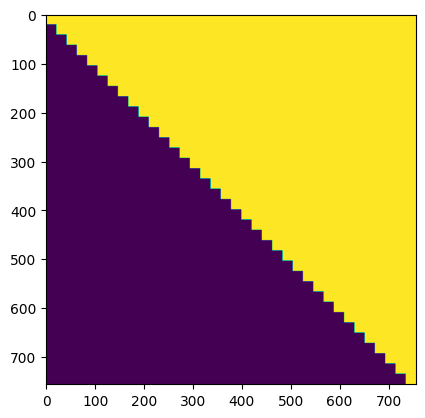

In [11]:
mask = (couplings == 0).to('cpu')
plt.imshow(mask[0,:,:])

In [12]:
fields.shape

torch.Size([1, 756])

## Create autoregressive sampler

In [13]:
from torch.nn.functional import softmax
from torch.distributions import Categorical

In [22]:
def sample_ardca(decoder, encodings, padding_mask, n_samples=10):
    """Sampler for arDCA, currently works only for a single sequence.
        NB: This function should not be used for standard Potts."""
        ## Put model in evaluation mdoel
    B, N, _ = encodings.shape
    samples = torch.zeros(n_samples, N, dtype=torch.long)
    decoder.eval()
    q = decoder.q
    ## fields shape: (B,N,q), we will consider B=1 for the moment
    ## Couplings shape: (B, N*q, N*q)
    couplings, fields = decoder.forward_ardca(encodings, padding_mask)
    fields = fields[0,:].reshape(N, q)
    p0 = softmax(fields[0,:], dim=0)
    
    samples[:,0] = Categorical(p0).sample((n_samples,))
    for sam in range(n_samples):
        for pos in range(1,N):
            Ham = fields[pos, :]
            for acc in range(pos):
                for aa in range(q):
                    #print(couplings[0, pos*q+aa, acc*q + samples[sam,acc]])
                    Ham[aa] += couplings[0, pos*q+aa, acc*q + samples[sam,acc]]
            
            p_pos = softmax(Ham, dim=0)
            samples[sam, pos] = Categorical(p_pos).sample()
    return samples


In [29]:
with torch.no_grad():
    samples=sample_ardca(decoder, rep_padded, padding_mask, n_samples=5000)

/home/luchinoprince/anaconda3/envs/IF/lib/python3.9/site-packages/torch/nn/modules/transformer.py:544: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(


In [30]:
samples

tensor([[20, 20, 20,  ...,  0, 20, 20],
        [20, 20, 20,  ..., 15,  3, 20],
        [20, 20, 20,  ..., 15,  2, 20],
        ...,
        [20, 20, 20,  ..., 14, 20, 20],
        [20, 20, 20,  ..., 14, 20, 20],
        [20, 20, 20,  ..., 14, 20, 20]])

In [31]:
cov_ardca = compute_covariance(samples, 21)

In [32]:
import re
fastapath = "/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Mutational_Data/alphafold_results_wildtype/MSAS_new/YAP1_HUMAN_1_b0.5.a2m.a3m"
with open(fastapath, mode="r") as f:
    lines = f.readlines()
lines = lines[1:]

msa_true = []
for line in range(len(lines)):
    if line%2 == 0:
        ## Take the end of sequence file
        seq_str = lines[line]#[0:-1]
        seq_num = []
        for char in seq_str:
            if char != '\n':
                seq_num.append(aa_index[char])
        if len(seq_num) == 36:
            msa_true.append(seq_num)
        else:
            print(failure)

msa_true = torch.tensor(msa_true)
cov_true = compute_covariance(msa_true[::,::], q=21)

In [33]:
scipy.stats.pearsonr(cov_true.flatten(), cov_ardca.flatten())

PearsonRResult(statistic=0.08244768980122827, pvalue=0.0)

## The Following code works for full Potts models, snce bmDCA cannot sample from arDCA due probabily to the correlations


In [12]:
## In this folder I will save the model in consideration, I won't save all of them due to memory
#auxiliary_model_dir = '/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Auxiliary_Potts'
auxiliary_model_dir = "/home/luchinoprince/Auxiliary_Data_bmdca/"
#auxiliary_model_dir = "."

B,N,_ = rep_padded.shape
with open(os.path.join(auxiliary_model_dir, "YAP1_HUMAN_couplings_fields.txt"), "w") as f:
    ## write J
    for i in range(N):
        for j in range(i+1, N):
            for aa1 in range(q):
                for aa2 in range(q):
                    J_el = couplings[0, i*q+aa1, j*q+aa2].detach().to('cpu').item()
                    line = "J " + str(i) + " " + str(j) + " "+ str(aa1) + " " + str(aa2) + " " + str(J_el) +"\n"
                    f.write(line)
    
    ## write h
    for i in range(N):
        for aa in range(q):
            h_el = fields[0, i*q+aa1].detach().to('cpu').item()
            line = "h " + str(i) + " " + str(aa) + " " + str(h_el) + "\n"
            f.write(line)

## Now we generate the samples from bmDCA

In [13]:
#auxiliary_model_dir = '/mnt/d/Data/InverseFolding/Auxiliary_Potts'
auxiliary_model_dir = "/home/luchinoprince/Auxiliary_Data_bmdca/"
out_dir = '/home/luchinoprince/Auxiliary_Data_bmdca/Auxiliary_Samples_Potts/'
out_file = 'samples.txt'
samples_path = os.path.join(auxiliary_model_dir, "YAP1_HUMAN_couplings_fields.txt")
## The ! creates a terminal command, to pass variable you need to put square brackets
!(bmdca_sample -p {samples_path} -d {out_dir} -o {out_file})

initializing sampler... 0.00166925 sec

sampling model with mcmc... 0.103868 sec
updating mcmc stats with samples... 0.00151743 sec
computing sequence energies and correlations... 0.0334793 sec
decreasing wait time to 600
increasing burn-in time to 150000
resampling...
writing temporary files
sampling model with mcmc... 0.0784021 sec
updating mcmc stats with samples... 0.0201524 sec
computing sequence energies and correlations... 0.0129283 sec
decreasing wait time to 360
increasing burn-in time to 225000
resampling...
writing temporary files
sampling model with mcmc... 0.0763142 sec
updating mcmc stats with samples... 0.00909351 sec
computing sequence energies and correlations... 0.0187616 sec
decreasing wait time to 216
increasing burn-in time to 337500
resampling...
writing temporary files
sampling model with mcmc... 0.067004 sec
updating mcmc stats with samples... 0.00227868 sec
computing sequence energies and correlations... 0.0243764 sec
decreasing wait time to 130
increasing burn

## Creating covariance for Potts

In [19]:
alphabet='ACDEFGHIKLMNPQRSTVWY-'
default_index = alphabet.index('-')
aa_index = defaultdict(lambda: default_index, {alphabet[i]: i for i in range(len(alphabet))})
aa_index_inv = dict(map(reversed, aa_index.items()))

In [15]:
file='samples_numerical.txt'
with open(os.path.join(out_dir,file), mode='r') as f:
    lines=f.readlines()

char_seq = [] ##36 is the lenght of YAP

for i in range(1, len(lines)):
    line = lines[i][0:-1].split(" ") ## I take out the end of file
    line_char = [aa_index_inv[int(idx)] for idx in line]
    char_seq.append(line_char)
    
## Now re-translate
for prot_idx in range(len(char_seq)):
    for aa in range(len(char_seq[prot_idx])):
        char_seq[prot_idx][aa] = aa_index[char_seq[prot_idx][aa]]
        
msa_t = torch.tensor(char_seq, dtype=torch.long)
cov_potts = compute_covariance(msa_t, 21)

In [16]:
import re
fastapath = "/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Mutational_Data/alphafold_results_wildtype/MSAS_new/YAP1_HUMAN_1_b0.5.a2m.a3m"
with open(fastapath, mode="r") as f:
    lines = f.readlines()
lines = lines[1:]

msa_true = []
for line in range(len(lines)):
    if line%2 == 0:
        ## Take the end of sequence file
        seq_str = lines[line]#[0:-1]
        seq_num = []
        for char in seq_str:
            if char != '\n':
                seq_num.append(aa_index[char])
        if len(seq_num) == 36:
            msa_true.append(seq_num)
        else:
            print(failure)

msa_true = torch.tensor(msa_true)
cov_true = compute_covariance(msa_true[::,::], q=21)


In [17]:
msa_true.shape

torch.Size([14484, 36])

In [18]:
msa_true.shape

torch.Size([14484, 36])

In [19]:
scipy.stats.pearsonr(cov_true.flatten(), cov_potts.flatten())

PearsonRResult(statistic=0.5997421587328298, pvalue=0.0)

## Let us take out the diagonal

In [41]:
N = len(native_seq)
t = torch.ones(q-1, q-1)
mask_cov = (1 - torch.block_diag(*([t]*(N)))).to(couplings.device)
mask_cov.requires_grad = False
mask_cov = mask_cov.type(torch.bool)
mask_flat = mask_cov.flatten()

In [24]:
#idxs = 5

#plt.imshow(cov_potts[0: idxs*(q-1), 0:idxs*(q-1)])
#plt.colorbar()

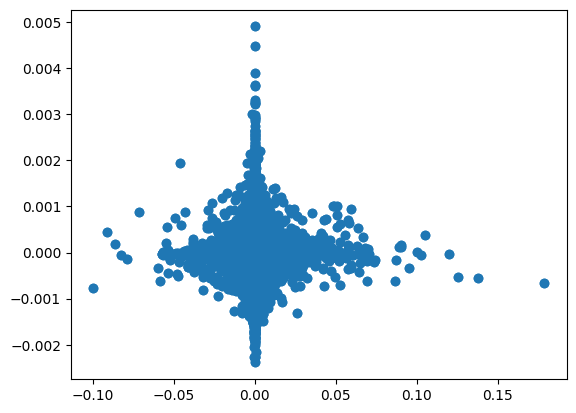

In [42]:
mask_cov = (1-torch.block_diag(*([t]*(N)))).to(couplings.device)
mask_cov.requires_grad = False
mask_cov = mask_cov.type(torch.bool)
mask_flat = mask_cov.flatten()

plt.scatter(cov_true.flatten()*(mask_flat), cov_potts.flatten()*(mask_flat))

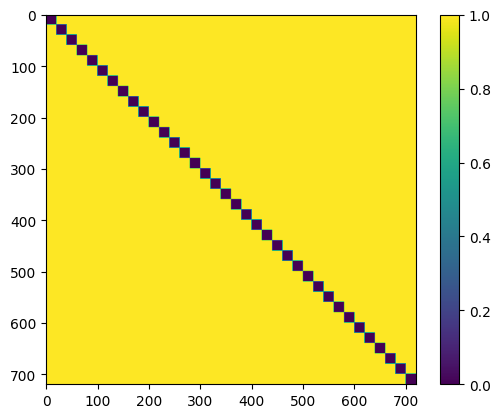

In [43]:
plt.imshow(mask_cov)
plt.colorbar()

In [44]:
mask_flat

tensor([False, False, False,  ..., False, False, False])

In [45]:
scipy.stats.pearsonr(cov_true.flatten()[mask_flat], cov_potts.flatten()[mask_flat])

PearsonRResult(statistic=-0.0017470616141295164, pvalue=0.21486867569117876)

## Now let us test the independent model ability to get correlations

In [23]:
device='cpu'
## This would work on windows
#bk_dir= 'D:/Data/InverseFolding/Intermediate_Models/'

bk_dir = '/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Intermediate_Models/'
fname_par = 'model_independent_epoch_300.pt'
checkpoint = torch.load(os.path.join(bk_dir, fname_par))

## Load parameters of the mode,
q=21
args = checkpoint['args']
n_layers = args['n_layers']
param_embed_dim = d_model = args['param_embed_dim']
input_encoding_dim = args['input_encoding_dim']
n_heads=args['n_heads']
n_param_heads=args['n_param_heads']
dropout=args['dropout']

decoder_ind = PottsDecoder(q, n_layers, d_model, input_encoding_dim, param_embed_dim, n_heads, n_param_heads, dropout=dropout);
decoder_ind.to(device);

decoder_ind.load_state_dict(checkpoint['model_state_dict']);
decoder_ind.eval();

512
512


In [24]:
rep_padded = pad_sequence(rep.unsqueeze(0), batch_first=True, padding_value=0.0)
padding_mask = (num_seq[0].unsqueeze(1)[:, 0, :] == q)
fields = decoder_ind.forward_indep(rep_padded, padding_mask)
fields=fields[0] ## We take out the batch dimensionality

In [25]:
rep_padded.shape

torch.Size([1, 36, 512])

In [26]:
len(num_seq[0])

1

In [27]:
num_seq[0].shape

torch.Size([1, 36])

In [28]:
N

36

In [29]:
-np.log(1/21)

3.044522437723423

In [30]:
from torch.distributions import Categorical

In [31]:
## I now creathe function to sample from the fields, as bmDCA cannot sample from just fields(previously noted)
def sample_ind(fields, n_samples=10000):
    ## I suppose individual fields, not batched
    N,q = fields.shape
    probs = torch.exp(-fields)/torch.sum(torch.exp(-fields), axis=1).unsqueeze(dim=-1)
    m = Categorical(probs=probs)
    msa = m.sample(sample_shape=(n_samples,))
    return msa

In [32]:
msa_ind = sample_ind(fields)
msa_ind.shape

torch.Size([10000, 36])

In [33]:
N,q = fields.shape
probs = torch.exp(-fields)/torch.sum(torch.exp(-fields), axis=1).unsqueeze(dim=-1)

In [34]:
torch.sum(probs,axis=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward1>)

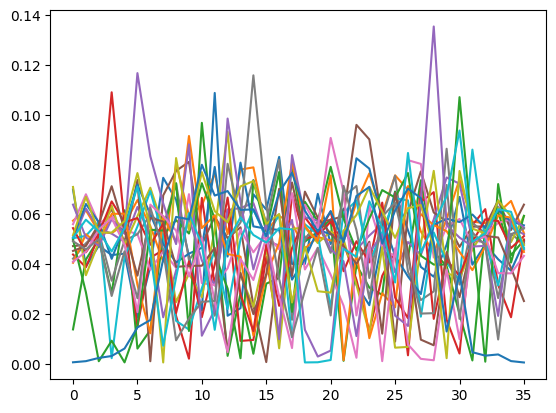

In [35]:
plt.plot(probs.detach().numpy());

In [36]:
## Let us see how is the loss for the sequence
nppl = 0
for i in range(N):
    #print(probs[i, num_seq[0][0, i]])
    nppl += torch.log(probs[i, num_seq[0][0, i]])
-nppl/N

tensor(4.9176, grad_fn=<DivBackward0>)

In [37]:
num_seq[0]

tensor([[ 2, 17, 12,  9, 12,  0,  5, 18,  3, 10,  0,  8, 16, 15, 15,  5, 13, 14,
         19,  4,  9, 11,  6,  7,  2, 13, 16, 16, 16, 18, 13,  2, 12, 14,  8,  0]])

In [38]:
native_seq

'DVPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRKA'

## Ok now we can test the correlation between the covariances also for the independent model

In [39]:
cov_ind = compute_covariance(msa_ind[::,::], q=21)

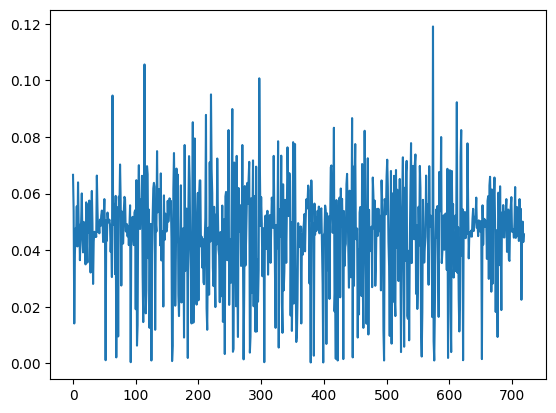

In [40]:
plt.plot(torch.diag(cov_ind))
## this is very bad... seems it is a toss up at every position(also with gaps, non-sense)

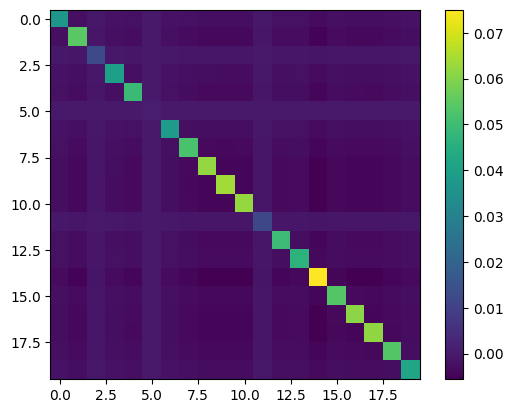

In [41]:
idxs = 1
pos=6
plt.imshow(cov_ind[pos*(q-1): pos*(q-1)+idxs*(q-1), pos*(q-1): pos*(q-1)+idxs*(q-1)])
plt.colorbar()
## is this sensible?

In [97]:
#cov_ind[4*(q-1): 4*(q-1)+idxs*(q-1), 4*(q-1): 4*(q-1)+idxs*(q-1)]

In [42]:
scipy.stats.pearsonr(cov_true.flatten(), cov_ind.flatten())

PearsonRResult(statistic=0.17025162606733307, pvalue=0.0)

In [43]:
scipy.stats.pearsonr(cov_true.flatten()[mask_flat], cov_ind.flatten()[mask_flat])

PearsonRResult(statistic=-0.00017258640267265527, pvalue=0.902484128346022)

In [44]:
scipy.stats.pearsonr(cov_true.flatten()[~mask_flat], cov_ind.flatten()[~mask_flat])

PearsonRResult(statistic=0.23391635736882826, pvalue=3.3373199500774917e-178)

## Now let us get an upper bound on the correlation we can get

In [1]:
%%script julia 
#using PlmDCA, PyCall;
using PyCall;
include("/home/luchinoprince/Dropbox/Old_OneDrive/Desktop/WSL_files/PlmDCA/src/PlmDCA.jl")
fastapath = "/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Mutational_Data/alphafold_results_wildtype/MSAS_new/YAP1_HUMAN_1_b0.5.a2m.a3m"
PlmDCA.plmdca_asym(fastapath)

Main.PlmDCA
"/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Mutational_Data/alphafold_results_wildtype/MSAS_new/YAP1_HUMAN_1_b0.5.a2m.a3m"
removing duplicate sequences... done: 14484 -> 13074
θ = 0.35059888487811297 threshold = 12.0
M = 13074 N = 36 Meff = 6684.716384744054
preprocessing took 1.034964344 seconds
site = 1	 pl = 0.7191	 time = 6.2553	exit status = FTOL_REACHED
site = 2	 pl = 1.3355	 time = 0.2430	exit status = FTOL_REACHED
site = 3	 pl = 1.1669	 time = 0.1875	exit status = FTOL_REACHED
site = 4	 pl = 0.9634	 time = 0.1907	exit status = FTOL_REACHED
site = 5	 pl = 0.8936	 time = 0.2125	exit status = FTOL_REACHED
site = 6	 pl = 2.2307	 time = 0.2136	exit status = FTOL_REACHED
site = 7	 pl = 1.4868	 time = 0.2261	exit status = FTOL_REACHED
site = 8	 pl = 0.2459	 time = 0.1561	exit status = FTOL_REACHED
site = 9	 pl = 2.2899	 time = 0.2207	exit status = FTOL_REACHED
site = 10	 pl = 2.3002	 time = 0.2325	exit status = FTOL_REACHED
site = 11	 pl 

In [5]:
couplings = np.load("couplings_MSA.npy")
fields = np.load("fields_MSA.npy")

In [6]:
fields.shape

(21, 36)

In [4]:
couplings = couplings.reshape((21,21,36,36))
fields =  fields.reshape(21,36)

NameError: name 'couplings' is not defined

In [51]:
## In this folder I will save the model in consideration, I won't save all of them due to memory
auxiliary_model_dir = '/home/luchinoprince/Auxiliary_Data_bmdca/Auxiliary_Samples_Potts/'
#auxiliary_model_dir = "."

B,N,_ = rep_padded.shape
with open(os.path.join(auxiliary_model_dir, "benchmark.txt"), "w") as f:
    ## write J
    for i in range(N):
        for j in range(i+1, N):
            for aa1 in range(q):
                for aa2 in range(q):
                    J_el = couplings[aa1, aa2, i, j]
                    line = "J " + str(i) + " " + str(j) + " "+ str(aa1) + " " + str(aa2) + " " + str(J_el) +"\n"
                    f.write(line)
    
    ## write h
    for i in range(N):
        for aa in range(q):
            h_el = fields[aa, i]
            line = "h " + str(i) + " " + str(aa) + " " + str(h_el) + "\n"
            f.write(line)

In [52]:
auxiliary_model_dir = '/home/luchinoprince/Auxiliary_Data_bmdca/Auxiliary_Samples_Potts/'
out_dir = auxiliary_model_dir = '/home/luchinoprince/Auxiliary_Data_bmdca/Auxiliary_Samples_Potts/'

out_file = 'samples_benchmark.txt'
samples_path = os.path.join(auxiliary_model_dir, "benchmark.txt")
## The ! creates a terminal command, to pass variable you need to put square brackets
!(bmdca_sample -p {samples_path} -d {out_dir} -o {out_file})

initializing sampler... 0.0100849 sec

sampling model with mcmc... 0.141615 sec
updating mcmc stats with samples... 0.012789 sec
computing sequence energies and correlations... 0.0442847 sec
decreasing wait time to 600
writing final sequences... done


In [53]:
file='samples_benchmark_numerical.txt'
with open(os.path.join(out_dir,file), mode='r') as f:
    lines=f.readlines()

char_seq = [] ##36 is the lenght of YAP

for i in range(1, len(lines)):
    line = lines[i][0:-1].split(" ") ## I take out the end of file
    line_char = [aa_index_inv[int(idx)] for idx in line]
    char_seq.append(line_char)
    
## Now re-translate
for prot_idx in range(len(char_seq)):
    for aa in range(len(char_seq[prot_idx])):
        char_seq[prot_idx][aa] = aa_index[char_seq[prot_idx][aa]]
        
msa_t = torch.tensor(char_seq, dtype=torch.long)
cov_bk = compute_covariance(msa_t, 21)

In [54]:
cov_bk

tensor([[ 4.0832e-03, -1.1890e-05, -2.2509e-04,  ..., -2.0910e-05,
          8.0730e-05, -1.8860e-05],
        [-1.1890e-05,  2.8916e-03, -1.5921e-04,  ..., -1.4790e-05,
         -1.3630e-05,  8.6660e-05],
        [-2.2509e-04, -1.5921e-04,  5.1886e-02,  ...,  1.2001e-04,
          4.1970e-05,  4.7460e-05],
        ...,
        [-2.0910e-05, -1.4790e-05,  1.2001e-04,  ...,  5.0740e-03,
         -2.3970e-05, -2.3460e-05],
        [ 8.0730e-05, -1.3630e-05,  4.1970e-05,  ..., -2.3970e-05,
          4.6779e-03, -2.1620e-05],
        [-1.8860e-05,  8.6660e-05,  4.7460e-05,  ..., -2.3460e-05,
         -2.1620e-05,  4.5788e-03]])

In [55]:
scipy.stats.pearsonr(cov_true.flatten(), cov_bk.flatten())

PearsonRResult(statistic=0.7695570681890711, pvalue=0.0)

In [56]:
scipy.stats.pearsonr(cov_true.flatten()[~mask_cov.flatten()], cov_bk.flatten()[~mask_cov.flatten()])

PearsonRResult(statistic=0.9395755708299316, pvalue=0.0)

In [57]:
mask_cov

tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False]])

# Now move to esm

In [68]:
samples_esm = []
for attempt in range(1000):
    print(f"We are at sample {attempt} out of {1000}", end="\r")
    sample = model.sample(coords)
    seq_num = []
    for char in sample:
        seq_num.append(aa_index[char])
    samples_esm.append(seq_num)
    #samples_esm.append(model.sample(coords))

In [69]:
samples_esm = torch.tensor(samples_esm)
cov_esm = compute_covariance(samples_esm, q=21)
corr_esm = torch.sum(cov_true * cov_esm)/torch.sqrt(torch.sum(cov_true**2)*torch.sum(cov_esm**2))


In [62]:
#plt.imshow(couplings.detach().numpy()[0, 0: 8*(q), 0:8*(q)])
#plt.colorbar()

In [70]:
corr_esm

tensor(0.4774)

In [64]:
cov_true.flatten()

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [65]:
scipy.stats.pearsonr(cov_true.flatten(), cov_esm.flatten())

PearsonRResult(statistic=0.3190384745441448, pvalue=0.0)

In [66]:
scipy.stats.pearsonr(cov_true.flatten()[mask_flat], cov_esm.flatten()[mask_flat])

PearsonRResult(statistic=0.02882796448769949, pvalue=3.9839365638054305e-93)

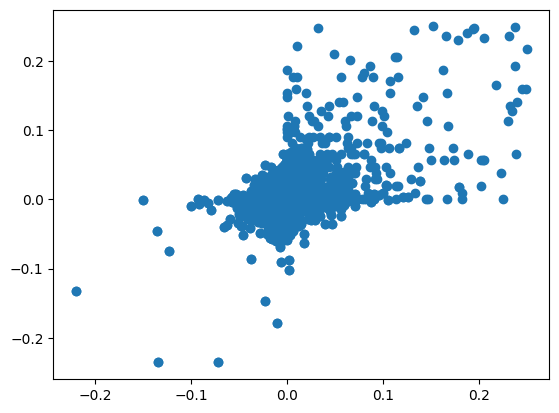

In [67]:
plt.scatter(cov_true.flatten(), cov_esm.flatten())

## Ok now we have to find how to iterate across values

In [ ]:
alignments_folder = "D:/Data/InverseFolding/Mutational_Data/alignments"
af_folder = '/mnt/d/Data/InverseFolding/Mutational_Data/alphafold_results_wildtype'
auxiliary_model_dir = '/mnt/d/Data/InverseFolding/Auxiliary_Potts'
out_dir = '/mnt/d/Data/InverseFolding/Auxiliary_Samples_Potts'
out_file = 'samples.txt'
samples_path = os.path.join(auxiliary_model_dir, "couplings_fields.txt")
model, alphabet = pretrained.esm_if1_gvp4_t16_142M_UR50() 
model.eval();

alphabet='ACDEFGHIKLMNPQRSTVWY-'
default_index = alphabet.index('-')
aa_index = defaultdict(lambda: default_index, {alphabet[i]: i for i in range(len(alphabet))})
aa_index_inv = dict(map(reversed, aa_index.items()))

## I comment these lines deu to the fact that there was a mistake and I didn't want to throws away all the computations
corrs_potts = []
corrs_esm = []
for msa in os.listdir(af_folder):
    it_prots+=1
    if msa.endswith('a2m') :
        id = prot[0:4]        
        check=0
        for af_pdb in os.listdir(af_folder):
            if 'ABLE' in msa:
                if ('ABLE' in af_pdb and af_pdb.endswith('pdb')):
                    if id == af_pdb[0:4]:
                        if 'rank_1' in af_pdb:
                            print(f"1 prot: {prot}, ID:{id}, afpdb:{af_pdb}, exp_file:{exp_file}")
                            check+=1
                            structure =  load_structure(os.path.join(af_folder, af_pdb))
                            coords, native_seq = extract_coords_from_structure(structure)
                            break
            elif 'hmmerbit' in msa:
                if ('hmmerbit' in af_pdb and af_pdb.endswith('pdb')):
                    if id == af_pdb[0:4]:
                        if 'rank_1' in af_pdb:
                            print(f"2 prot: {prot}, ID:{id}, afpdb:{af_pdb}, exp_file:{exp_file}")
                            check+=1
                            structure =  load_structure(os.path.join(af_folder, af_pdb))
                            coords, native_seq = extract_coords_from_structure(structure)
                            break
            elif 'BRCT' in msa:
                if ('BRCT' in af_pdb and af_pdb.endswith('pdb')):
                    if id == af_pdb[0:4]:
                        if 'rank_1' in af_pdb:
                            print(f"3 prot: {prot}, ID:{id}, afpdb:{af_pdb}, exp_file:{exp_file}")
                            check+=1
                            structure =  load_structure(os.path.join(af_folder, af_pdb))
                            coords, native_seq = extract_coords_from_structure(structure)
                            break
            else:
                crit = ['ABLE', 'hmmerbit', 'BRCT']
                x = [c in af_pdb for c in crit]
                if (sum(x)==0 and af_pdb.endswith('pdb')):
                    if id == af_pdb[0:4]:
                        if 'rank_1' in af_pdb:
                            print(f"4 prot: {prot}, ID:{id}, afpdb:{af_pdb}, exp_file:{exp_file}")
                            check+=1
                            structure =  load_structure(os.path.join(af_folder, af_pdb))
                            coords, native_seq = extract_coords_from_structure(structure)     
                            break

        if check==0:
            print("I have not found an AF pdb")         
            continue
        
        ## Get representation and Potts model
        rep = esm.inverse_folding.util.get_encoder_output(model, alphabet, coords)
        rep_padded = pad_sequence(rep.unsqueeze(0), batch_first=True, padding_value=0.0)
        padding_mask = (num_seq[0].unsqueeze(1)[:, 0, :] == q)
        couplings, fields = decoder(rep_padded, padding_mask)
        
        ## SAVE THE MODEL
        B,N,_ = rep_padded.shape
        ## I save with a common name to avoid saving too many objects
        with open(os.path.join(auxiliary_model_dir, "couplings_fields.txt"), "w") as f:
            ## write J
            for i in range(N):
                for j in range(i+1, N):
                    for aa1 in range(q):
                        for aa2 in range(q):
                            J_el = couplings[0, i*q+aa1, j*q+aa2].detach().to('cpu').item()
                            line = "J " + str(i) + " " + str(j) + " "+ str(aa1) + " " + str(aa2) + " " + str(J_el) +"\n"
                            f.write(line)

            ## write h
            for i in range(N):
                for aa in range(q):
                    h_el = fields[0, i*q+aa1].detach().to('cpu').item()
                    line = "h " + str(i) + " " + str(aa) + " " + str(h_el) + "\n"
                    f.write(line)
                    
        ## Create the sample from potts
        !(bmdca_sample -p {samples_path} -d {out_dir} -o {out_file})
        
        ##Read file and compute covariance for Potts
        file='samples_numerical.txt'
        with open(os.path.join(out_dir,file), mode='r') as f:
            lines=f.readlines()

        char_seq = [] 

        for i in range(1, len(lines)):
            line = lines[i][0:-1].split(" ") ## I take out the end of file
            line_char = [aa_index_inv[int(idx)] for idx in line]
            char_seq.append(line_char)

        ## Now re-translate
        for prot_idx in range(len(char_seq)):
            for aa in range(len(char_seq[prot_idx])):
                char_seq[prot_idx][aa] = aa_index[char_seq[prot_idx][aa]]

        msa_t = torch.tensor(char_seq, dtype=torch.long)
        cov_potts = compute_covariance(msa_t, 21)
        
        ## Compute true covariance
        fpath = os.path.join(af_folder, msa)
        with open(fpath, mode="r") as f:
            lines = f.readlines()
        lines = lines[2:]

        msa_true = []
        for line in range(len(lines)):
            if line%2 == 0:
                ## Take the end of sequence file
                seq_str = lines[line][0:-1]
                seq_num = []
                for char in seq_str:
                    seq_num.append(aa_index[char])
                if len(seq_num) == N: ## Take only sequences of length N
                    msa_true.append(seq_num)

        msa_true = torch.tensor(msa_true)
        cov_true = compute_covariance(msa_true[::,::], q=21)
        
        ##Compute and append correlation between potts and true
        corrs_potts.append(scipy.stats.pearsonr(cov_true.flatten(), cov_potts.flatten()))


        
        
    